## Part I: CNN for handwritten digit recognition
### Introduction:

- In this section, you will implement a CNN model and training loop with Pytorch to predict the category of the handwritten digit image.
- In this experiment, we use the MNIST dataset, a image dataset including digit from 0 to 9, with a training set of 60,000 examples, and a test set of 10,000 examples.

### Task:
- You need to design the model and complete the training loop with Pytorch.
- You need to achieve at least 90% averaged Top1 Acc on test data.
- You need to download the data files mnist_train.csv and mnist_test.csv from the following links:

    mnist_train.csv https://www.dropbox.com/s/gm82o0atvvpwc0f/mnist_train.csv?dl=0
    
    mnist_test.csv https://www.dropbox.com/s/jm1bz8rtp0ecfw1/mnist_test.csv?dl=0
    
  and place those files in the same folder with ipynb files.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image

from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

In [21]:
# The arguments of the experiment
class Args:
    def __init__(self):
        # Based on the availablity of GPU, decide whether to run the experiment on cuda or cpu.
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # The random seed for the exp.
        self.seed = 1
        # The mini batch size of training and testing data. If you find your machine runs very slow 
        # or experience OOM issues, you can set a smaller batch size
        self.batch_size = 20
        # The epochs of the exps. The referenced model achieve over 95% test accuracy after 1 epoch.
        self.epochs = 10
        # The learning rate of the SGD optimizer
        self.lr = 0.1
        # The momentum of SGD optimizer
        self.momentum = 0.5
        # how many iterations to display the training stats
        self.log_interval = 50
        # The height of input image
        self.img_h = 28
        # The width of the input image
        self.img_w = 28
        
args = Args()
torch.manual_seed(args.seed)

### 0. The dataloader
- Load the data from csv file
- Return the the image and label

In [4]:
class MNIST_DATASET(Dataset):
    def __init__(self, csv_path, height, width, transform=None):
        """
        Custom dataset example for reading data from csv

        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transform = transform

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)
    
transformations = transforms.Compose([transforms.ToTensor()])

mnist_train = \
    MNIST_DATASET('./mnist_train.csv',
                             args.img_h, args.img_w,
                             transformations)
mnist_test = \
    MNIST_DATASET('./mnist_test.csv',
                             args.img_h, args.img_w,
                             transformations)
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                                    batch_size=args.batch_size,
                                                    shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                                    batch_size=args.batch_size,
                                                    shuffle=False)

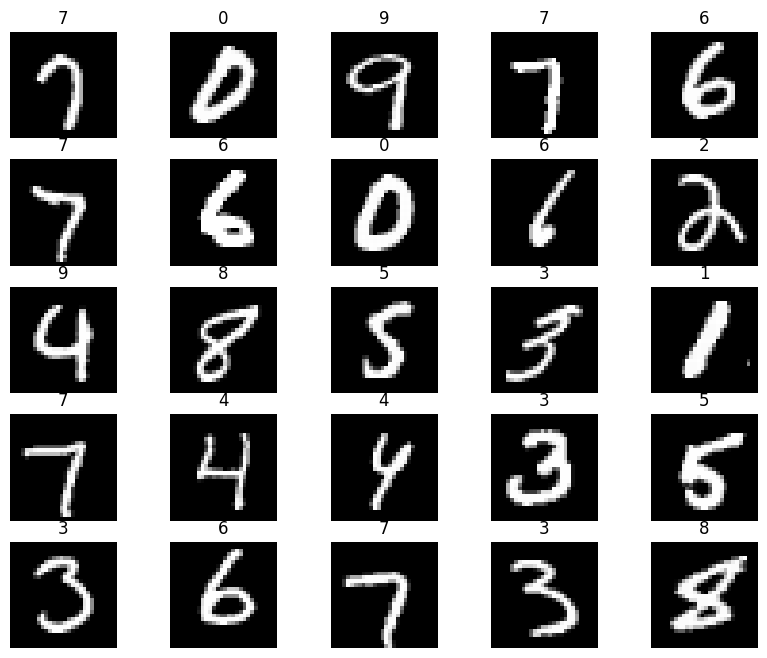

In [5]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 1. (TODO) The CNN Model [15 points]
- Complete the following section to create a CNN model for handwritten digit image recognition.
- The model should consist of convolutional layers, pooling layers and fully connected layers.
- The output should be the categorical distribution over 10 categories (digits 0-9)

In [55]:
class Model(nn.Module):
    """Custom CNN model to recognize the input handwritten digit image"""
    def __init__(self):
        """ Define and instantiate your layers"""

        # Initializing the parent class (nn.Module).
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Pooling doesn't change the number of output channels,
        # but it can make the outputs from the channels smaller.
        self.pool  = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        """ 
        Run forward pass on input image X
        
        Args:
            x: torch tensor of input image, 
                with shape of [batch_size * 1 * img_h * img_w]
        
        Return:
            out: torch tensor of predicted categorical distribution  
                on input images, with shape of [batch_size, 10]
        """
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

### 2. (TODO) The Training Loop [15 points]
- Instantiate the model and optimizer
- Select proper loss function for this task
- Complete the training loop

In [57]:
device = args.device
print('Using device {}'.format(device))
cnn = Model()
cnn = cnn.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=cnn.parameters(),
					       lr=args.lr,
					       momentum=args.momentum)

def train(num_epochs, cnn, loss_func, optimizer, train_loader):
   # Looping over data multiple times
   for epoch in range(num_epochs):

      running_loss = 0
      for i, data in enumerate(train_loader):
         # unpacking our input data
         inputs, labels = data

         # zero the parameter gradients
         optimizer.zero_grad()

         outputs = cnn.forward(inputs)
         loss = loss_func(outputs, labels)
         loss.backward()
         # Running gradient descent on our weights
         optimizer.step()
         
         running_loss += loss.item()
         if (i % args.log_interval) == 0:
            print(f"Epoch #{epoch+1}, loss = {running_loss}")

train(args.epochs, cnn, loss_func, optimizer, mnist_train_loader)

Using device cpu
Epoch #1, loss = 2.306811809539795
Epoch #1, loss = 112.12329018115997
Epoch #1, loss = 183.29360157251358
Epoch #1, loss = 217.5230459868908
Epoch #1, loss = 238.32424567639828
Epoch #1, loss = 254.10167549643666
Epoch #1, loss = 270.4641312388703
Epoch #1, loss = 286.88628242816776
Epoch #1, loss = 299.8039001254365
Epoch #1, loss = 312.30734301777557
Epoch #1, loss = 324.05339663801715
Epoch #1, loss = 334.3133472329937
Epoch #1, loss = 345.29640956176445
Epoch #1, loss = 354.1836100486107
Epoch #1, loss = 363.7175509878434
Epoch #1, loss = 373.08949548518285
Epoch #1, loss = 382.6635562335141
Epoch #1, loss = 393.1724797356874
Epoch #1, loss = 401.3699633209035
Epoch #1, loss = 409.75348051195033
Epoch #1, loss = 418.16801687772386
Epoch #1, loss = 425.71852442459203
Epoch #1, loss = 432.36669895611703
Epoch #1, loss = 441.66048037819564
Epoch #1, loss = 449.9793248459464
Epoch #1, loss = 457.14238548313733
Epoch #1, loss = 464.29874403297435
Epoch #1, loss = 471.1

In [60]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in mnist_test_loader:
            test_output = cnn(images.to(device))
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels.to(device)).sum().item()
            total += labels.size(0)
    print('Test Accuracy of the model on the 10000 test images: %.2f %%' % (correct*100.0/total))
test()
    

Test Accuracy of the model on the 10000 test images: 98.74 %
